In [1]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import numba
from numba import jit, njit
from scipy.ndimage import convolve, generate_binary_structure


In [2]:
lattice_size = [16,32,64,128]


def lattice(N):
    return 2*np.random.randint(2, size=(N, N))-1


lattice1 = lattice(lattice_size[0])
lattice2 = lattice(lattice_size[1])
lattice3 = lattice(lattice_size[2])
lattice4 = lattice(lattice_size[3])


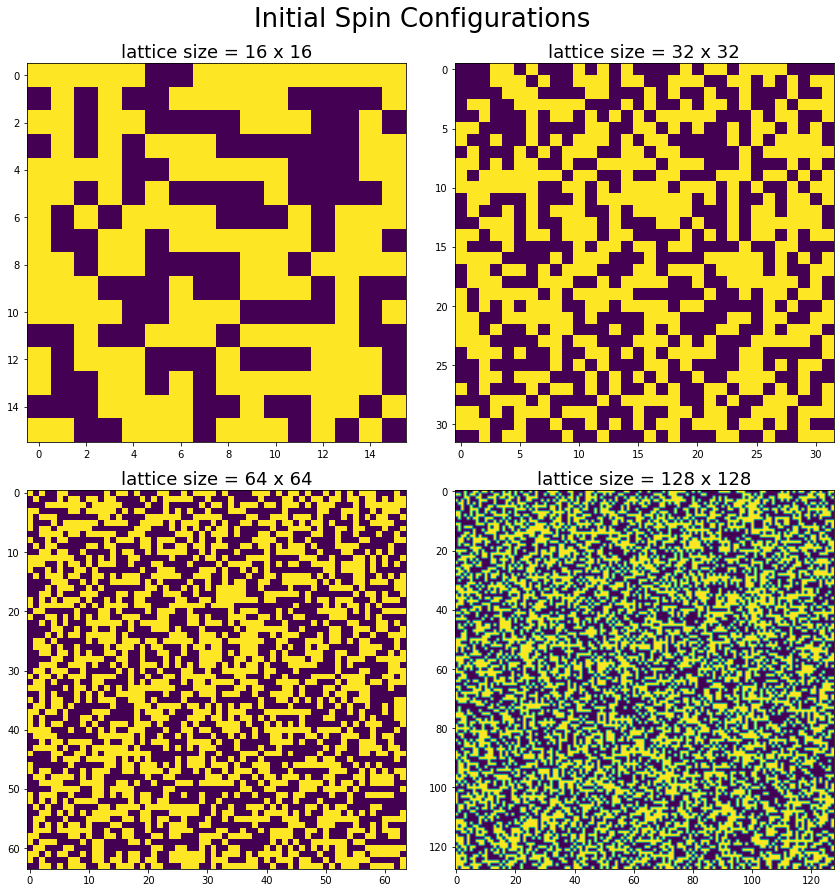

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

ax = axes[0, 0]
ax.imshow(lattice1)
ax.set_title(
    f'lattice size = {lattice_size[0]} x {lattice_size[0]}', fontsize=18)
ax = axes[0, 1]
ax.imshow(lattice2)
ax.set_title(
    f'lattice size = {lattice_size[1]} x {lattice_size[1]}', fontsize=18)
ax = axes[1, 0]
ax.imshow(lattice3)
ax.set_title(
    f'lattice size = {lattice_size[2]} x {lattice_size[2]}', fontsize=18)
ax = axes[1, 1]
ax.imshow(lattice4)
ax.set_title(
    f'lattice size = {lattice_size[3]} x {lattice_size[3]}', fontsize=18)
fig.tight_layout()
fig.suptitle(r'Initial Spin Configurations', y=1.03, size=26)
plt.show()


In [4]:
nt = 50           # number of temperature points
eqsteps = 2500    # number of MC sweeps for equilibration
mcsteps = 2500   # number of MC sweeps for calculation

Temperature = np.linspace(1.53, 3.28, nt)
Energy, Magnetization, SpecificHeat, Susceptibility = np.zeros(
    (4, nt)), np.zeros((4, nt)), np.zeros((4, nt)), np.zeros((4, nt))
# n=1/(mcsteps*N*N)


In [5]:
@jit(nopython=True)
def mcmove(state, beta):
    N = np.shape(state)[0]
    for i in range(N):
        for j in range(N):
            a = np.random.randint(0, N)
            b = np.random.randint(0, N)
            sig_i = state[a, b]
            sig_j = state[(a+1) % N, b] + state[(a-1) % N, b] + \
                state[a, (b+1) % N] + state[a, (b-1) % N]
            delta_E = 2*sig_i*sig_j

            if delta_E < 0:
                sig_i *= -1
            elif rand() < np.exp(-delta_E*beta):
                sig_i *= -1
            state[a, b] = sig_i
    return state


@jit(nopython=True)
def calcEnergy(config):

    energy = 0
    N = np.shape(config)[0]
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i, j]
            nb = config[(i+1) % N, j] + config[i, (j+1) % N] + \
                config[(i-1) % N, j] + config[i, (j-1) % N]
            energy += -nb*S
    return energy/2


@jit(nopython=True)
def calcMag(config):
    mag = np.sum(config)
    return mag


In [6]:
for item in range(len(lattice_size)):
    if item == 0:
        state = lattice1
    elif item == 1:
        state = lattice2
    elif item == 2:
        state = lattice3
    else:
        state = lattice4

    n = np.shape(state)[0]
    for t in range(nt):
        E = M = 0
        Beta = 1/Temperature[t]

        for i in range(eqsteps):
            mcmove(state, Beta)

        for i in range(mcsteps):
            mcmove(state, Beta)
            E += calcEnergy(state)
            M += abs(calcMag(state))

        Energy[item, t] = E/(mcsteps*n*n)
        Magnetization[item, t] = M/(mcsteps*n*n)


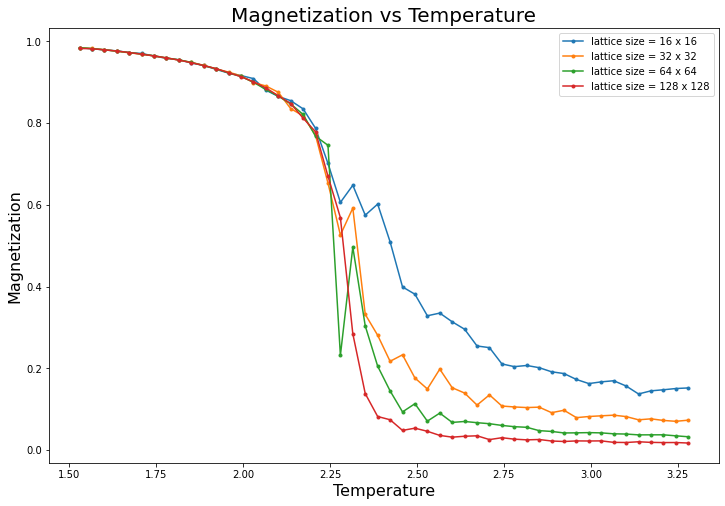

In [7]:
plt.figure(figsize=(12,8))
plt.plot(Temperature, Magnetization[0], '.-',
         label=f'lattice size = {lattice_size[0]} x {lattice_size[0]}')
plt.plot(Temperature, Magnetization[1], '.-',
         label=f'lattice size = {lattice_size[1]} x {lattice_size[1]}')
plt.plot(Temperature, Magnetization[2], '.-',
         label=f'lattice size = {lattice_size[2]} x {lattice_size[2]}')
plt.plot(Temperature, Magnetization[3], '.-',
         label=f'lattice size = {lattice_size[3]} x {lattice_size[3]}')
plt.title('Magnetization vs Temperature', fontsize=20)
plt.xlabel('Temperature', fontsize=16)
plt.ylabel('Magnetization', fontsize=16)
plt.legend()
plt.show()


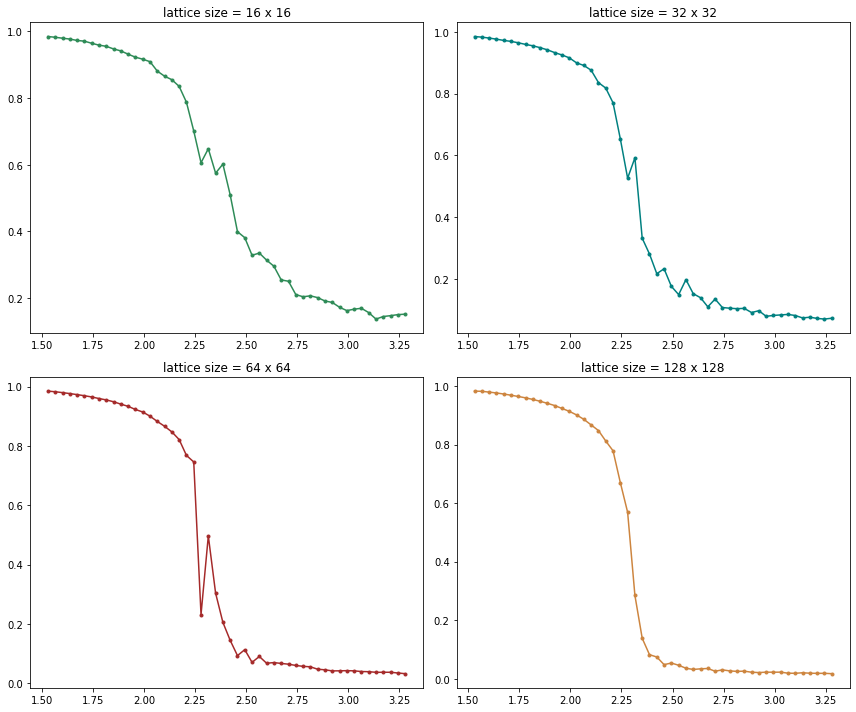

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))

ax = axes[0, 0]
ax.plot(Temperature, Magnetization[0], '.-', color='seagreen')
ax.set_title(f'lattice size = {lattice_size[0]} x {lattice_size[0]}')
ax = axes[0, 1]
ax.plot(Temperature, Magnetization[1], '.-', color='teal')
ax.set_title(f'lattice size = {lattice_size[1]} x {lattice_size[1]}')
ax = axes[1, 0]
ax.plot(Temperature, Magnetization[2], '.-', color='brown')
ax.set_title(f'lattice size = {lattice_size[2]} x {lattice_size[2]}')
ax = axes[1, 1]
ax.plot(Temperature, Magnetization[3], '.-', color='peru')
ax.set_title(f'lattice size = {lattice_size[3]} x {lattice_size[3]}')
fig.tight_layout()
# fig.suptitle(r'Initial Spin Configurations', y=1.03, size=26)
plt.show()


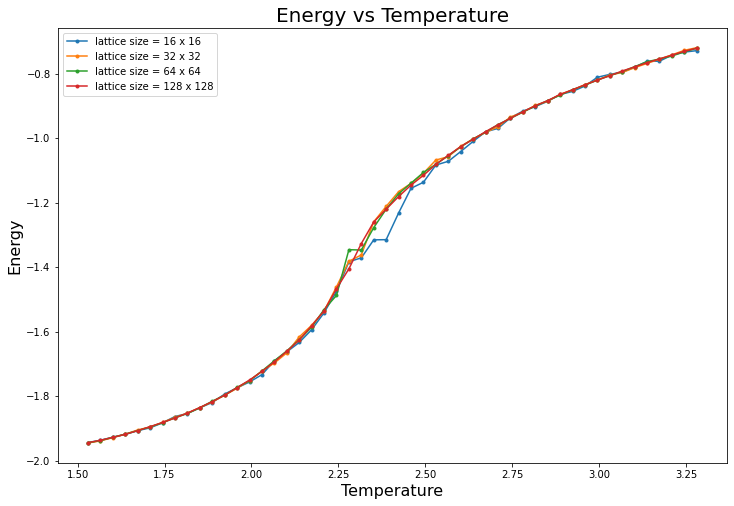

In [9]:
plt.figure(figsize=(12,8))
plt.plot(Temperature, Energy[0], '.-',
         label=f'lattice size = {lattice_size[0]} x {lattice_size[0]}')
plt.plot(Temperature, Energy[1], '.-',
         label=f'lattice size = {lattice_size[1]} x {lattice_size[1]}')
plt.plot(Temperature, Energy[2], '.-',
         label=f'lattice size = {lattice_size[2]} x {lattice_size[2]}')
plt.plot(Temperature, Energy[3], '.-',
         label=f'lattice size = {lattice_size[3]} x {lattice_size[3]}')
plt.title('Energy vs Temperature', fontsize=20)
plt.xlabel('Temperature', fontsize=16)
plt.ylabel('Energy', fontsize=16)
plt.legend()
plt.show()


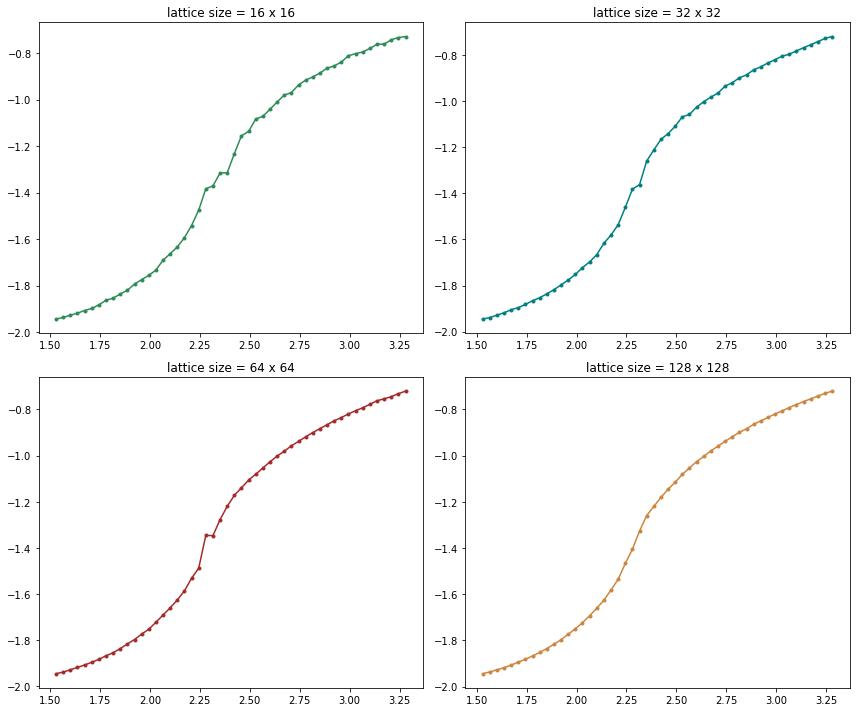

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

ax = axes[0, 0]
ax.plot(Temperature, Energy[0], '.-', color='seagreen')
ax.set_title(f'lattice size = {lattice_size[0]} x {lattice_size[0]}')
ax = axes[0, 1]
ax.plot(Temperature, Energy[1], '.-', color='teal')
ax.set_title(f'lattice size = {lattice_size[1]} x {lattice_size[1]}')
ax = axes[1, 0]
ax.plot(Temperature, Energy[2], '.-', color='brown')
ax.set_title(f'lattice size = {lattice_size[2]} x {lattice_size[2]}')
ax = axes[1, 1]
ax.plot(Temperature, Energy[3], '.-', color='peru')
ax.set_title(f'lattice size = {lattice_size[3]} x {lattice_size[3]}')
fig.tight_layout()
# fig.suptitle(r'Initial Spin Configurations', y=1.03, size=26)
plt.show()


In [11]:
np.shape(state)[0]

128

In [12]:
np.random.randint(0, 50)

28

In [13]:
Mag1, Mag2, Mag3, Mag4 = Magnetization


In [14]:
from scipy.optimize import curve_fit


In [15]:
def model_f(x, a, b, c):
    return a/(1+b*np.exp(10.3*(x-c)))


In [22]:
popt, pcov = curve_fit(model_f, Temperature, Mag4, p0=[2,7 ,2.2])


In [23]:
popt


array([  0.98344732, 173.89554723,   2.77238696])

In [24]:
a_opt, b_opt, c_opt = popt
x_model = np.linspace(min(Temperature), max(Temperature), 100)
y_model = model_f(x_model, a_opt, b_opt, c_opt)


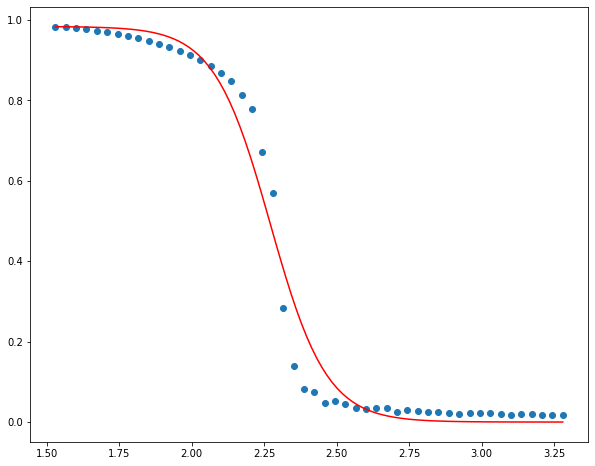

In [25]:
plt.figure(figsize=(10, 8))
plt.scatter(Temperature, Mag4)
plt.plot(x_model, y_model, '-', color='r')
